In [16]:
!pip install pymde emblaze # gensim

  Using cached pymde-0.2.3-cp313-cp313-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached emblaze-0.11.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached torch-2.8.0-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached colormath-3.0.0-py3-none-any.whl
  Using cached umap_learn-0.5.9.post2-py3-none-any.whl.metadata (25 kB)
  Using cached flask-3.1.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached Flask_SocketIO-5.5.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached eventlet-0.40.3-py3-none-any.whl.metadata (5.4 kB)
  Using cached anywidget-0.9.18-py3-none-any.whl.metadata (8.9 kB)
  Using cached psygnal-0.14.2-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x8

In [2]:
import pandas as pd

df = pd.read_parquet('./work/data/hiscore_updates.parquet')

# retain only rows where mode=0
df = df[df['mode'] == 0]

# retain only rows where pp>=75
df = df[df['pp'] >= 75]

# drop columns:
# - mode
# - rank
# - is_classic
df = df.drop(columns=['mode', 'rank', 'is_classic'])

# convert types:
# user -> int32
# pp -> f32
# mods -> int32
df['user'] = df['user'].astype('int32')
df['pp'] = df['pp'].astype('float32')
df['mods'] = df['mods'].astype('int32')

print(f"Retained: {len(df)}")

df.head()

Retained: 42606069


,user,beatmap_id,score,pp,mods,score_time,update_time
291,55,48067,1631540,96.584702,0,2013-03-23 03:22:26,2025-03-08 21:25:48
292,55,48067,1631540,86.331703,0,2013-03-23 11:22:26,2017-02-01 13:30:30
294,55,116876,3484018,87.260300,0,2013-05-20 13:54:29,2025-03-13 01:57:58
295,55,116876,3484018,82.921402,0,2013-05-20 21:54:29,2017-02-01 13:30:30
296,55,102891,4221594,89.478996,0,2013-05-21 13:05:41,2025-03-08 21:25:48


In [3]:
"""
We only care about the following mods:
 - DT or NC -> DT
 - HD
 - EZ
 - HR
 - HT
 - FL

And we return them as a concatenated string in alphabetical order (e.g. "DTFLHR")
"""
def decode_mods_bitset(bitset: int):
    mods = ''
    if bitset & (1 << 6):
        mods += 'DT'
    if bitset & (1 << 1):
        mods += 'EZ'
    if bitset & (1 << 10):
        mods += 'FL'
    # if bitset & (1 << 3):
    #     mods += 'HD'
    if bitset & (1 << 4):
        mods += 'HR'
    if bitset & (1 << 8):
        mods += 'HT'

    return mods

# Apply the function to the 'mods' column
df['mods'] = df['mods'].apply(decode_mods_bitset)

In [4]:
df['score_id'] = df['beatmap_id'].astype(str) + '_' + df['mods'].astype(str)

In [5]:
# pre-sort the hiscores df by (user ascending, score_id ascending, update_time descending)
df.sort_values(by=['user', 'score_id', 'update_time'], ascending=[True, True, False], inplace=True)

# retain only the top pp score for each user+score_id
df = df.drop_duplicates(subset=['user', 'score_id'], keep='first')

In [6]:
user_counts = df.groupby('score_id')['user'].nunique()
user_counts.head()

score_id
1000052_DTHR     3
1000075_         3
1000075_DT       1
1000168_        86
1000168_HR       3
Name: user, dtype: int64

In [7]:
# find all unique score IDs by user id=4093752 and dump to csv
user_scores = df[df['user'] == 4093752]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/my_score_ids.csv', index=False)

# same for 3637436
user_scores = df[df['user'] == 3637436]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/blankz_score_ids.csv', index=False)

# same for 35452149
user_scores = df[df['user'] == 35452149]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/big_tomas_score_ids.csv', index=False)

# same for 32290754
user_scores = df[df['user'] == 32290754]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/peblohh_score_ids.csv', index=False)

In [8]:
# dump some extra metadata about scores to csv:
#
# - score_id
# - average pp
# - number of unique users

score_metadata = df.groupby('score_id').agg(
    avg_pp=('pp', 'mean'),
    num_users=('user', 'nunique')
).reset_index()

score_metadata.to_csv('./work/data/score_metadata.csv', index=False)

# create dict for local use
avg_pp_by_score_id = score_metadata.set_index('score_id')['avg_pp'].to_dict()

In [9]:
# Count how many 'score_id' have exactly one unique user
single_user_score_ids = user_counts[user_counts == 1].count()

print(f"Number of 'score_id' with exactly one unique user: {single_user_score_ids}")

two_user_score_ids = user_counts[user_counts == 2].count()

print(f"Number of 'score_id' with exactly two unique users: {two_user_score_ids}")

three_user_score_ids = user_counts[user_counts == 3].count()

print(f"Number of 'score_id' with exactly three unique users: {three_user_score_ids}")

four_user_score_ids = user_counts[user_counts == 4].count()

print(f"Number of 'score_id' with exactly four unique users: {four_user_score_ids}")

# filter out scores with low user counts
#
# there are way fewer very high pp plays (>500) than there are low pp plays, so we want
# to be more strict when deciding whether to filter low pp plays
#
# Filter out scores with less than 50 unique users at pp=100 and below, and linearly scale
# the filter threshold down to 5 users at pp=500.
def should_retain(score_id):
    avg_pp = avg_pp_by_score_id[score_id]
    num_users = user_counts[score_id]

    edge0 = 100
    edge1 = 500
    activation = max(0, min(1, (avg_pp - edge0) / (edge1 - edge0)))
    # scale from [0, 1] to [50, 5]
    threshold = 50 - (50 - 5) * activation

    return num_users >= threshold

before_score_count = len(df)
# df = df[df['score_id'].isin(user_counts[user_counts >= 50].index)]
df = df[df['score_id'].apply(should_retain)]

print(f'Filtered scores from {before_score_count} -> {len(df)}')

Number of 'score_id' with exactly one unique user: 59178
Number of 'score_id' with exactly two unique users: 23312
Number of 'score_id' with exactly three unique users: 13808
Number of 'score_id' with exactly four unique users: 9522
Filtered scores from 35773606 -> 34743773


In [10]:
unique_scores = df['score_id'].unique()

# populate mapping from score id to index in the co-occurrence matrix
score_to_index = {score: i for i, score in enumerate(unique_scores)}

df['score_ix'] = df['score_id'].apply(lambda x: score_to_index[x]).astype('int32')

print(f"Unique score count: {len(unique_scores)}")

Unique score count: 45071


In [11]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix
from numba import jit
import gc

def condense_matrices(main_csr, uniq_score_count, rows, cols, vals):
    coo = coo_matrix((vals, (rows, cols)), shape=(uniq_score_count, uniq_score_count), dtype=np.float32)
    main_csr += coo.tocsr()

    gc.collect()

    return main_csr

chunk_size = 100_000_000

@jit(nopython=True)
def fill_arrays(cur_scores: np.ndarray, cur_scores_pps: np.ndarray, cur_score_ix: int, rows: np.ndarray, cols: np.ndarray, vals: np.ndarray, arr_ix: int) -> int:
    for i in range(cur_score_ix - 1):
        score_i_ix = cur_scores[i]

        for j in range(i + 1, cur_score_ix):
            # compute weight based on relative pp difference
            #
            # 0% difference -> weight = 2
            # 25% difference -> weight = 1
            # 50% difference -> weight = 0
            # >50% difference -> weight = 0
            #
            # decreasing linearly from 1 to 0 as difference increases.  Anything over 50% difference is 0.
            pp_i = cur_scores_pps[i]
            pp_j = cur_scores_pps[j]
            max_pp = max(pp_i, pp_j)
            relative_diff = abs(pp_i - pp_j) / max_pp
            weight = 0 if relative_diff > 0.5 else (1 - (relative_diff / 0.5)) * 2

            if weight <= 0:
                continue

            score_j_ix = cur_scores[j]
            rows[arr_ix] = score_i_ix
            cols[arr_ix] = score_j_ix
            vals[arr_ix] = weight
            arr_ix += 1

            if arr_ix >= chunk_size:
                raise ValueError("Array index out of bounds")

    return arr_ix

def compute_cooccurrence_matrix(uniq_score_count: int, df: pd.DataFrame) -> csr_matrix:
    main_csr = csr_matrix((uniq_score_count, uniq_score_count), dtype=np.float32)

    # collect up chunks of matrix entries
    rows = np.ndarray(chunk_size, dtype=np.int32)
    cols = np.ndarray(chunk_size, dtype=np.int32)
    vals = np.ndarray(chunk_size, dtype=np.float32)
    arr_ix = 0

    cur_user_id = 0
    # re-use typed array for current user's scores
    cur_scores = np.ndarray(50000, dtype=np.int32)
    cur_scores_pps = np.ndarray(50000, dtype=np.float32)
    cur_score_ix = 0

    row_ix = 0
    for row in df.itertuples():
        if row_ix % 2000000 == 0:
            print(f"Processing row {row_ix} of {len(df)}")
            main_csr.sum_duplicates()
            print(f"Main CSR nnz: {main_csr.nnz}")

        user_id = row.user
        score_ix = row.score_ix
        pp = row.pp

        if cur_user_id != user_id:
            needed_space = (cur_score_ix * (cur_score_ix - 1)) // 2
            if needed_space + arr_ix >= chunk_size:
                main_csr = condense_matrices(main_csr, uniq_score_count, rows[:arr_ix], cols[:arr_ix], vals[:arr_ix])
                arr_ix = 0

            arr_ix = fill_arrays(cur_scores, cur_scores_pps, cur_score_ix, rows, cols, vals, arr_ix)

            cur_user_id = user_id
            cur_scores[0] = score_ix
            cur_scores_pps[0] = pp
            cur_score_ix = 1
        else:
            cur_scores[cur_score_ix] = score_ix
            cur_scores_pps[cur_score_ix] = pp
            cur_score_ix += 1

        row_ix += 1

    print(f"final main CSR nnz: {main_csr.nnz}")

    return main_csr

In [12]:
cooccurrence_matrix = compute_cooccurrence_matrix(len(unique_scores), df)

Processing row 0 of 34743773
Main CSR nnz: 0
Processing row 2000000 of 34743773
Main CSR nnz: 32838857
Processing row 4000000 of 34743773
Main CSR nnz: 60404934
Processing row 6000000 of 34743773
Main CSR nnz: 85794751
Processing row 8000000 of 34743773
Main CSR nnz: 99232719
Processing row 10000000 of 34743773
Main CSR nnz: 111641495
Processing row 12000000 of 34743773
Main CSR nnz: 128126844
Processing row 14000000 of 34743773
Main CSR nnz: 138487616
Processing row 16000000 of 34743773
Main CSR nnz: 147998783
Processing row 18000000 of 34743773
Main CSR nnz: 162798721
Processing row 20000000 of 34743773
Main CSR nnz: 172808356
Processing row 22000000 of 34743773
Main CSR nnz: 183051149
Processing row 24000000 of 34743773
Main CSR nnz: 193122847
Processing row 26000000 of 34743773
Main CSR nnz: 202533536
Processing row 28000000 of 34743773
Main CSR nnz: 211274339
Processing row 30000000 of 34743773
Main CSR nnz: 219269151
Processing row 32000000 of 34743773
Main CSR nnz: 227483989
Pro

In [13]:
# symmetrize
sym_cooccurrence_matrix = (cooccurrence_matrix + cooccurrence_matrix.transpose()).tocsr()
print(f"Symmetrized co-occurrence matrix nnz: {sym_cooccurrence_matrix.nnz}")

Symmetrized co-occurrence matrix nnz: 472168060


In [14]:
# Now, we want to sparsify the matrix further by retaining only the top n co-occurrences for each score_id
#
# Since we've already symmetrized the matrix, we can just iterate over the rows, retain the top n co-occurrences,
# and build a new sparse matrix from that.  We also trim out any low-count co-occurrences.
#
# While we're at it, we also need to map the values from co-occurrence counts to a distance metric such that
# higher counts are closer to 0. We'll use the following formula:
#
# distance = 1 / log(count)

rows, cols, data = [], [], []

topn = 700
for row_ix in range(sym_cooccurrence_matrix.shape[0]):
    if row_ix % 1000 == 0:
        print(f"Processing row {row_ix} of {sym_cooccurrence_matrix.shape[0]}")

    row = sym_cooccurrence_matrix.getrow(row_ix)
    top_indices = np.argsort(row.data)[-topn:]
    # filter out low-count co-occurrences
    top_indices = top_indices[row.data[top_indices] > 2]
    rows.extend([row_ix] * len(top_indices))
    cols.extend(row.indices[top_indices])
    # mapped_data = -np.log(row.data[top_indices] / row.data.sum())
    mapped_data = np.reciprocal(np.log(row.data[top_indices]))
    data.extend(mapped_data)
    # data.extend(row.data[top_indices])
    # data.extend(np.ones(len(top_indices), dtype=np.float32))

top_cooccurrence_matrix = csr_matrix((data, (rows, cols)), shape=sym_cooccurrence_matrix.shape, dtype=np.float32)
print(f"Top co-occurrence matrix nnz: {top_cooccurrence_matrix.nnz}")

Processing row 0 of 45071
Processing row 1000 of 45071
Processing row 2000 of 45071
Processing row 3000 of 45071
Processing row 4000 of 45071
Processing row 5000 of 45071
Processing row 6000 of 45071
Processing row 7000 of 45071
Processing row 8000 of 45071
Processing row 9000 of 45071
Processing row 10000 of 45071
Processing row 11000 of 45071
Processing row 12000 of 45071
Processing row 13000 of 45071
Processing row 14000 of 45071
Processing row 15000 of 45071
Processing row 16000 of 45071
Processing row 17000 of 45071
Processing row 18000 of 45071
Processing row 19000 of 45071
Processing row 20000 of 45071
Processing row 21000 of 45071
Processing row 22000 of 45071
Processing row 23000 of 45071
Processing row 24000 of 45071
Processing row 25000 of 45071
Processing row 26000 of 45071
Processing row 27000 of 45071
Processing row 28000 of 45071
Processing row 29000 of 45071
Processing row 30000 of 45071
Processing row 31000 of 45071
Processing row 32000 of 45071
Processing row 33000 of

In [23]:
import pymde

import numpy as np
import matplotlib.pyplot as plt

cooccurrence_graph = pymde.preprocess.Graph(top_cooccurrence_matrix)

In [ ]:
n_neighbors = 10
embedding_dim = 3

mde = pymde.preserve_neighbors(
    cooccurrence_graph,
    # shortest_path_graph,
    embedding_dim=embedding_dim,
    attractive_penalty=pymde.penalties.Linear,
    # repulsive_penalty=None,
    verbose=True,
    # max_distance=1.2,
    n_neighbors=n_neighbors,
    init="random",
    # device='cuda'
)

In [ ]:
# mde.constraint = pymde.constraints.Standardized()
# mde.distortion_function.attractive_penalty = pymde.penalties.Log1p(mde.distortion_function.attractive_penalty.weights)

In [19]:
embedding = mde.embed(verbose=True, max_iter=2000, print_every=50)

Oct 11 04:51:04 AM: Fitting a centered embedding into R^3, for a graph with 45071 items and 882009 edges.
Oct 11 04:51:04 AM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Oct 11 04:51:05 AM: iteration 0000 | distortion 1.249704 | residual norm 0.0109617 | step length 1000 | percent change 2.98326
Oct 11 04:51:06 AM: iteration 0050 | distortion 0.551441 | residual norm 0.00254188 | step length 1 | percent change 3.46668
Oct 11 04:51:07 AM: iteration 0100 | distortion 0.413452 | residual norm 0.00337673 | step length 1 | percent change 4.05576
Oct 11 04:51:09 AM: iteration 0150 | distortion 0.333732 | residual norm 0.00224786 | step length 1 | percent change 0.461277
Oct 11 04:51:11 AM: iteration 0200 | distortion 0.310969 | residual norm 0.0012903 | step length 1 | percent change 0.495488
Oct 11 04:51:12 AM: iteration 0250 | distortion 0.302171 | residual norm 0.0013126 | step length 1 | percent change 0.309359
Oct 11 04:51:14 AM: iteration 0300 | distortion 0.2

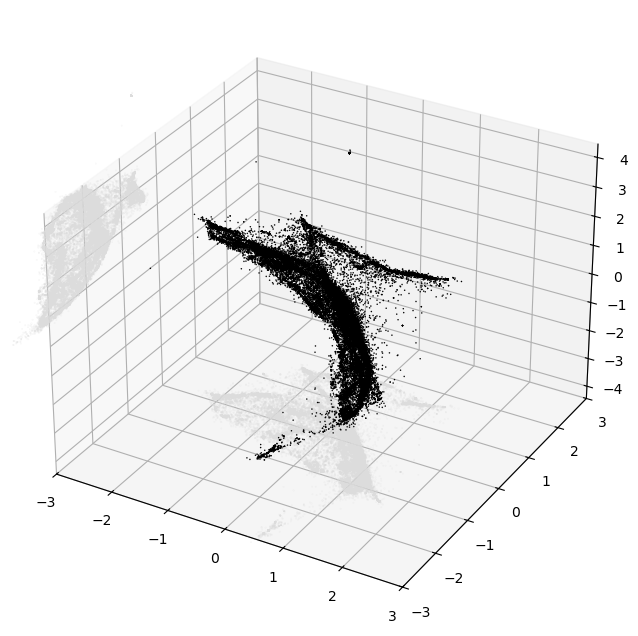

In [20]:
mde.plot(colors=['black'])
# plot from x=-3 to 3
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [21]:
# export in w2v format
fname = f'./work/data/pymde_{embedding_dim}d_{n_neighbors}n_bigger.w2v'
with open(fname, 'wt') as f:
    # write header
    f.write('{} {}\n'.format(len(embedding), mde.embedding_dim))
    for i in range(len(embedding)):
        row = embedding[i].tolist()
        f.write('{} {}\n'.format(i, ' '.join(map(str, row))))
fname

'./work/data/pymde_3d_10n_bigger.w2v'

In [22]:
# write dataframe mapping score_id to index
mapping = [(score_id, i) for score_id, i in score_to_index.items()]
mapping_df = pd.DataFrame(mapping, columns=['score_id', 'index'])
mapping_df.to_csv(f'{fname}.csv', index=False)
mapping_df.head()

# code to load:
# mapping_df = pd.read_csv('./work/data/score_id_mapping.csv')
# score_id_by_ix = mapping_df.set_index('index')['score_id'].to_dict()

,score_id,index
0,1007525_,0
1,1057659_,1
2,105950_,2
3,1089041_,3
4,109479_,4
